# Анализ данных сервиса Яндекс.Недвижмость

#### В нашем распоряжении – архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

#### Задача исследования – научиться определять рыночную стоимость квартир, найти параметры, которые позволят в дальнейшем построить автоматизированную систему оценки стоимости недвижимости в объявлениях. Это позволит найти аномальные объявления и пресечь мошенничество.

##### Часть 1. Изучение общей информации:
* [1.1 Изученеие файла с данными, загрузка библиотек](#1-bullet)
* [1.2 Определение и изучение пропущенных значений](#2-bullet)

##### Часть 2. Подготовка данных:
* [2.1 Обработка пропусков](#3-bullet)
* [2.2 Приведение данных к нужным типам](#4-bullet)
* [2.3 Поиск дубликатов](#5-bullet)

##### Часть 3. Финальная подготовка таблицы к анализу:
* [Создание вспомогательных колонок](#6-bullet)

##### Часть 4. Анализ
* [Характеристики самых востребованных квартир](#7-bullet)
* [Время продажи квартир (как долго висят объявления?)](#8-bullet)
* [Сокращение выборки](#9-bullet)
* [Какие факторы сильнее остальных влияют на стоимость квартир?](#10-bullet)
* [Санкт-Петербург](#11-bullet)
* [Окрестности](#12-bullet)

##### [Выводы](#13-bullet)

### Часть 1. Изучение общей информации
<a id='1-bullet'></a>
#### 1.1 Обзор файла с данными, загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Откроем документ с данными как DataFrame

In [2]:
data = pd.read_csv('real_estate_data.csv',delimiter='\t')

Рассмотрим первые 5 строк таблицы

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [5]:
data.query('locality_name == "Санкт-Петербург"')['locality_name'].count()/data.shape[0]*100

66.3361323262585

In [6]:
data.query('locality_name == "Санкт-Петербург"')['locality_name'].count()/data['locality_name'].count()*100

66.47357293868922

In [7]:
data.query('locality_name == "Санкт-Петербург"')['locality_name'].count()/data['cityCenters_nearest'].count()*100

86.47414741474148

66% датасета – объявления о продаже недвижимости в Санкт-Петербурге. При этом, если брать в рассчет только объявления, в которых указано расстояние до центра, то представленность Санкт-Петербурга вырастет до 86%.

Обратим внимание на соответствие типов данных и колонок. Тип object подходит лишь для одной из колонок – locality name, однако он встречается и в других колонках: first_day_exposition и is_apartment. Рассмотрим эти колонки внимательнее

In [8]:
data['first_day_exposition'][0]

'2019-03-07T00:00:00'

In [9]:
data['first_day_exposition'].isna().sum()

0

Необходимо будет перевести данные из колонки first_day_exposition в тип datetime. Пропусков в этой колонке нет

In [10]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [11]:
print('Доля пропусков в колонке is_apartment:',round(data['is_apartment'].isna().sum()/data.shape[0]*100,2),'%.')

Доля пропусков в колонке is_apartment: 88.29 %.


Колонка is_apartment должна иметь тип bool, но в ней встречаются пропуски (много пропусков – более 88%), что с этим делать пока не ясно. Для нашей задачи знание о том, что жилье является апартаментом (в нем нельзя прописаться, как в квартире) или не является апартаментом – на этом этапе кажется несущественным.

<font color='purple'>Большое количество пропусков в колонке скорее всего объясняется тем, что жилье не является апартаментом – при заполнении пользователи просто пропускали эту графу. Далее следует заменить пропуски на False.</font>

<a id='#2-bullet'></a>
#### 1.2 Определение и изучение пропущенных значений

Определим колонки, в которых есть NaN, а также оценим количество пропусков в них.

In [12]:
for col in data.columns:
    if data[col].notna().sum() < data.shape[0]:
        empty = data.shape[0]-(data[col].notna().sum())
        empty_share = round(empty/data.shape[0]*100,2)
        if empty_share <1:
            print(col,'Количество NaN: ',empty,'\nДоля пропусков низкая: ',empty_share,'%. Эти строки можно выбросить. \n')

        else:
            print(col,'Количество NaN: ',empty,'\nДоля пропусков значимая: ',empty_share,'%. Эти строки стоит расссмотреть внимательно. \n')

ceiling_height Количество NaN:  9195 
Доля пропусков значимая:  38.8 %. Эти строки стоит расссмотреть внимательно. 

floors_total Количество NaN:  86 
Доля пропусков низкая:  0.36 %. Эти строки можно выбросить. 

living_area Количество NaN:  1903 
Доля пропусков значимая:  8.03 %. Эти строки стоит расссмотреть внимательно. 

is_apartment Количество NaN:  20924 
Доля пропусков значимая:  88.29 %. Эти строки стоит расссмотреть внимательно. 

kitchen_area Количество NaN:  2278 
Доля пропусков значимая:  9.61 %. Эти строки стоит расссмотреть внимательно. 

balcony Количество NaN:  11519 
Доля пропусков значимая:  48.61 %. Эти строки стоит расссмотреть внимательно. 

locality_name Количество NaN:  49 
Доля пропусков низкая:  0.21 %. Эти строки можно выбросить. 

airports_nearest Количество NaN:  5542 
Доля пропусков значимая:  23.38 %. Эти строки стоит расссмотреть внимательно. 

cityCenters_nearest Количество NaN:  5519 
Доля пропусков значимая:  23.29 %. Эти строки стоит расссмотреть вним

Мы можем разделить колонки, в которых есть пропуски на несколько групп:
- Группа 1. колонки, пропущенные значения которых нельзя восстановить из контекста и доля которых так мала (<1%), что соответствующие строки можно удалить:

        floors_total (количество этажей в доме),

        locality_name (название района)

    
- Группа 2. колонки, пропущенные значения которых можно заполнить соответствующим медианным значением:

        ceiling_height (высота потолков), 

        living_area (жилплощадь), 

        kitchen_area (площадь кухни)
    
    
- Группа 3. колонки, пропущенные значения в которых обозначают отсутствие чего-либо, например, балкона или пруда по близости:

        balcony (количество балконов),

        airports_nearest (расстояние до ближайшего аэропорта в метрах),

        cityCenters_nearest (расстояние до центра города в метрах),

        parks_nearest (расстояние до ближайшего парка в метрах),

        ponds_around3000 (число водоёмов в радиусе 3 км),

        ponds_nearest (расстояние до ближайшего водоёма)

    
- Группа 4. проблемные колонки, пропущенные значения в которых нельзя восстановить, но и доля пропусков в них высока:

        is_apartment (является апартаментами), 

        days_exposition (сколько дней было размещено объявление)

# Часть 2. Подготовка данных
<a id='3-bullet'></a>
## 2.1 Обработка пропусков

### Группа 1. Удаление строк

Удалим NaN в колонках floors_total и locality_name – там они встречаются редко (составляют менее 1% колонки), и мы можем удалить эти строки безболезненно для выборки. Восстановить количество этажей в доме и название района мы по другим колонкам не можем.

In [13]:
data = data.loc[~data[['floors_total','locality_name']].isnull().any(axis=1)]

Проверим, удалось ли удалить строки

In [14]:
print(data['floors_total'].isnull().sum(),data['locality_name'].isnull().sum())

0 0


Строки удалены

### Группа 3. Замена пропусков на 0

##### Балконы

Рассмотрим колонку, в которой указывается количество балконов

In [15]:
data['balcony'].value_counts()

1.0    4187
0.0    3680
2.0    3656
5.0     304
4.0     182
3.0      81
Name: balcony, dtype: int64

In [16]:
data['balcony'].isna().sum()

11475

Никаких аномальных значений не обнаружено. Однако в колонке много пропусков – перейдем к замене пропусков на 0. Если в описании квартиры графа о количестве балконов не заполнена, вероятно балкона в помещении просто нет.

In [17]:
data['balcony'] = data['balcony'].fillna(0)

In [18]:
data['balcony'].value_counts()

0.0    15155
1.0     4187
2.0     3656
5.0      304
4.0      182
3.0       81
Name: balcony, dtype: int64

In [19]:
data['balcony'].isna().sum()

0

##### Данные об окрестностях

Что касается пропусков в данных об окрестностях, которые подгружаются автоматически, а не заполняются автором объявления, к ним остаются вопросы. Хорошо бы связаться с разработчиками и сообщить им, что в серьёзной доле данных обнаружены пропуски. Возможно, они дадут разъяснения и скажут, что если в столбце пропуск – значит в радиусе таком-то не обнаружено соответствующих объектов. Или же перезагрузят датасет.

В отсутствии возможности связаться с разработчиками будем считать, что Nan означает отсутствие объекта и заполнять пропуски не будем.

### Группа 2. Заполним пропуски в колонках с высотой потолков и площадью помещений медианными значениями

Для того, чтобы заполнить пропуски правдоподобными значениями, будем считать медианы по группам, в зависимости от количества комнат в квартире. Рассмотрим, квартиры с каким количеством комнат представлены в выборке.

In [20]:
data['rooms'].value_counts()

1     8004
2     7897
3     5779
4     1172
5      325
0      194
6      104
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

Вызывают подозрения квартиры с нулём комнат. Может быть это квартиры-студии?

In [21]:
data.query('rooms == 0')['studio'].mean()

0.6958762886597938

Действительно, в большинстве случаев это квартиры-студии.

#### Вернемся к задаче: нам необходимо заполнить пропуски в колонках:
    ceiling_height (высота потолков), 
    
    living_area (жилплощадь), 
    
    kitchen_area (площадь кухни)

Сгруппируем объявления по стоимости квадратного метра.

#### Добавим в таблицу data колонку со стоимостью квадратного метра жилья в объявлении

In [22]:
data['square_m'] = data['last_price']/data['total_area']

Построим гистограмму для колонки square_m

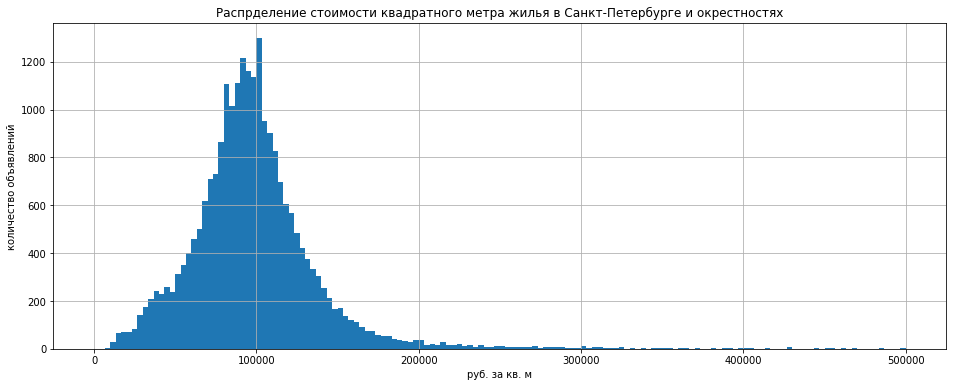

In [23]:
data['square_m'].hist(bins=150,range=(0,500000),figsize=(16,6))
plt.title('Распрделение стоимости квадратного метра жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

В целом распределение цен выглядит как нормальное – с длинным хвостом в сторону увеличения цены.

Расмотрим основную часть гистограммы и хвост отдельно.

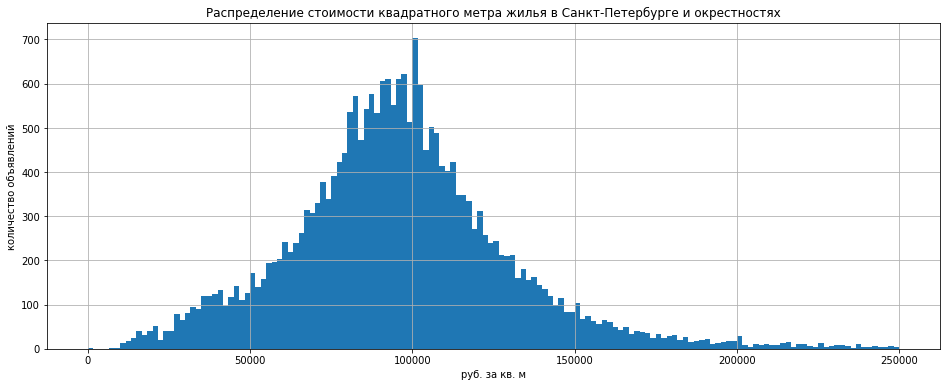

In [24]:
data.loc[data['square_m'] < 250000]['square_m'].hist(bins=150,range=(0,250000),figsize=(16,6))
plt.title('Распределение стоимости квадратного метра жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

Заметно, что хвост начинается с отметки чуть менее 200 000 рублей за квадратный метр

Для того, чтобы построить гистограмму для "хвоста", определим максимальное значение в колонке square_m

In [25]:
data['square_m'].max()

1907500.0

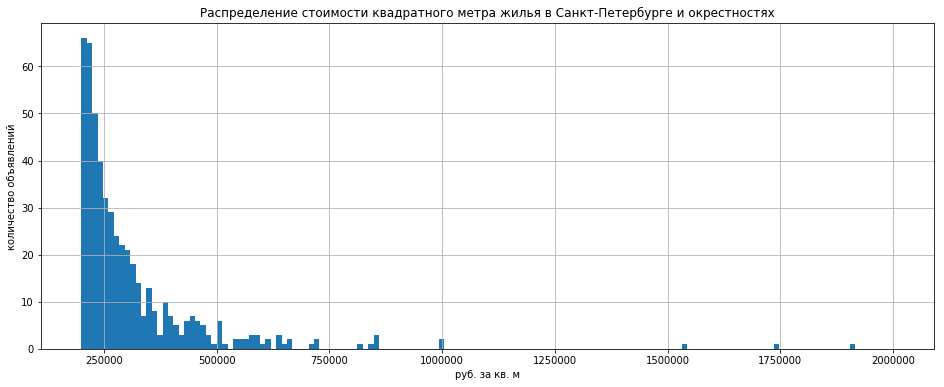

In [26]:
data.loc[data['square_m'] > 200000]['square_m'].hist(bins=150,range=(200000,2000000),figsize=(16,6))
plt.title('Распределение стоимости квадратного метра жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

Создадим датафрейм с экстремально дорогими помещениями, стоимость одного квадратного метра в них превышает 200 000 рублей и рассмотрим его подробнее.

In [27]:
extremely_expensive = data.loc[data['square_m'] > 200000]

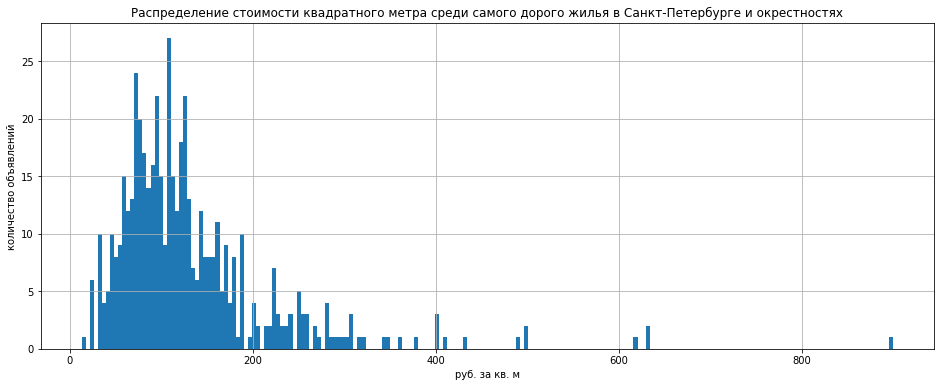

In [28]:
extremely_expensive['total_area'].hist(bins=200,figsize=(16,6))
plt.title('Распределение стоимости квадратного метра среди самого дорого жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

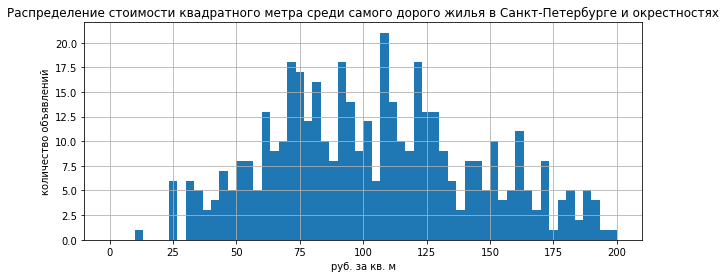

In [29]:
extremely_expensive['total_area'].hist(bins=60,range=(0,200),figsize=(10,4))
plt.title('Распределение стоимости квадратного метра среди самого дорого жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

Большая часть экстремально дорогих помещений имеет площадь до 200 кв. м. При этом, у гистограммы есть длинный хвост уходящий к значениям в 800 кв м.

Странными объявлениями о продаже такой дорогой недвижимости будут те, в которых либо не будет фотографий вовсе, либо их будет мало. Рассмотрим, сколько таких объявлений.

In [30]:
extremely_expensive.query('total_images == 0')['total_images'].count()

15

In [31]:
extremely_expensive.query('total_images > 0 and total_images < 3')['total_images'].count()

29

In [32]:
extremely_expensive.query('total_images < 3')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_m
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
411,1,40662000.0,151.00,2014-12-09T00:00:00,3,NaN,8.0,85.00,3,NaN,...,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,594.0,269284.768212
546,0,6000001.0,25.00,2018-11-16T00:00:00,1,3.00,5.0,NaN,5,False,...,0.0,Санкт-Петербург,25169.0,3871.0,1.0,207.0,1.0,776.0,17.0,240000.040000
1109,1,34878556.0,95.80,2014-12-09T00:00:00,2,NaN,6.0,58.30,5,True,...,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0,364076.784969
1254,1,36001900.0,142.30,2017-08-25T00:00:00,3,3.00,11.0,79.30,6,False,...,0.0,Санкт-Петербург,28282.0,6941.0,2.0,365.0,3.0,215.0,NaN,253000.000000
1299,0,17100000.0,63.30,2017-12-26T00:00:00,2,3.10,4.0,38.60,4,NaN,...,0.0,Санкт-Петербург,22927.0,1454.0,1.0,715.0,3.0,33.0,86.0,270142.180095
2201,2,31500000.0,136.36,2018-03-31T00:00:00,3,NaN,13.0,35.88,11,NaN,...,0.0,Санкт-Петербург,35966.0,11487.0,0.0,NaN,3.0,363.0,227.0,231006.160164
2708,1,11060000.0,51.20,2018-02-16T00:00:00,1,3.00,7.0,15.00,5,NaN,...,1.0,Санкт-Петербург,39412.0,10186.0,1.0,1424.0,3.0,204.0,90.0,216015.625000
3000,1,19370000.0,90.30,2018-02-01T00:00:00,2,NaN,8.0,48.40,4,NaN,...,0.0,Санкт-Петербург,25988.0,6556.0,2.0,496.0,1.0,334.0,232.0,214507.198228
4464,2,13500000.0,54.50,2016-03-29T00:00:00,1,NaN,7.0,25.50,3,NaN,...,2.0,Санкт-Петербург,26398.0,7359.0,3.0,257.0,2.0,566.0,312.0,247706.422018


Запомним, что в сегменте очень дешевых и очень дорогих квартир есть те, в которых нет фотографий и это странно.

Вернемся к основной части гистограммы стоимости квадратного метра

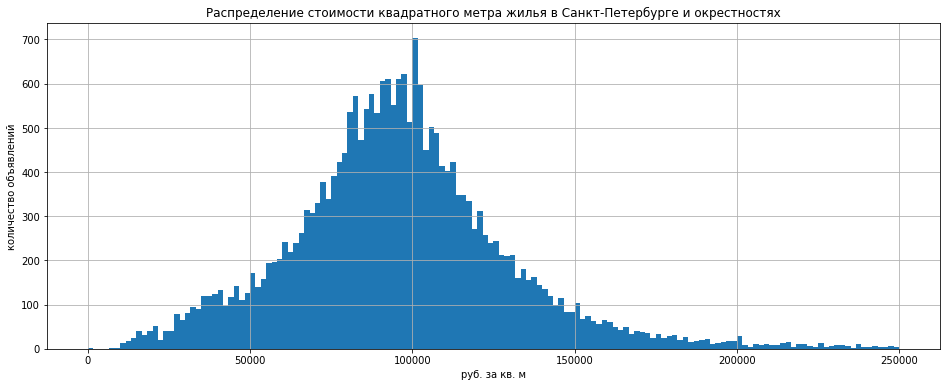

In [33]:
data.loc[data['square_m'] < 250000]['square_m'].hist(bins=150,range=(0,250000),figsize=(16,6))
plt.title('Распределение стоимости квадратного метра жилья в Санкт-Петербурге и окрестностях')
plt.xlabel('руб. за кв. м')
plt.ylabel('количество объявлений')
plt.show()

In [34]:
print(data.loc[data['square_m'] < 250000]['square_m'].describe())

count     23285.000000
mean      95989.422932
std       33697.087936
min         111.834862
25%       76215.895611
50%       94594.594595
75%      113247.863248
max      249375.000000
Name: square_m, dtype: float64


Разделим выборку на 4 группы, согласно значением квантилей.

In [35]:
square_quintiles = []
for i in [0.25,0.5,0.75]:
    square_quintiles.append(data['square_m'].quantile(i))

In [36]:
def square_cat(value):
    if value < square_quintiles[0]:
        return 1
    if value < square_quintiles[1]:
        return 2
    if value < square_quintiles[2]:
        return 3
    else:
        return 4

In [37]:
data['square_cat'] = data['square_m'].apply(square_cat)

Проверим, везде ли проставились значения.

In [38]:
data['square_cat'].unique()

array([4, 2, 3, 1])

In [39]:
data['square_cat'].count(),data.shape[0]

(23565, 23565)

Все в порядке.

Заполняем значения в колонке ceiling height

In [40]:
data.groupby('square_cat')['ceiling_height'].median()

square_cat
1    2.57
2    2.60
3    2.65
4    2.80
Name: ceiling_height, dtype: float64

In [41]:
column = 'ceiling_height'
grouped_data = data.groupby('square_cat')[column].median()
medians_by_cat = grouped_data.loc[range(1, 5)].tolist()

In [42]:
def get_median_by_cat(square_cat):
    return medians_by_cat[square_cat-1]

In [43]:
for column in ['ceiling_height','living_area','kitchen_area']:
    medians_by_cat = []
    grouped_data = data.groupby('square_cat')[column].median()
    medians_by_cat = grouped_data.loc[range(1, 5)].tolist()
    data.loc[data[column].isnull(),column] = (
        data.loc[data[column].isnull(),'square_cat'].
        apply(get_median_by_cat)
    )    

In [44]:
print(data['ceiling_height'].isna().sum(),
      data['living_area'].isna().sum(),
      data['kitchen_area'].isna().sum())

0 0 0


Пропуски в колонках с высотой потолка, жилплощадью и площадью кухни заполнены.

### Группа 4.  Невосстанавливаемые пропуски, которые встречаются в значимой части выборки

is_apartment (88.29 % пропусков) – не значимая колонка для нашей задачи, не будем её использовать.

days_exposition (13.42 % пропусков) – возможно, значимая колонка для нашей задачи. Заполним её медианным значением в зависимости от категории дороговизны кв м.

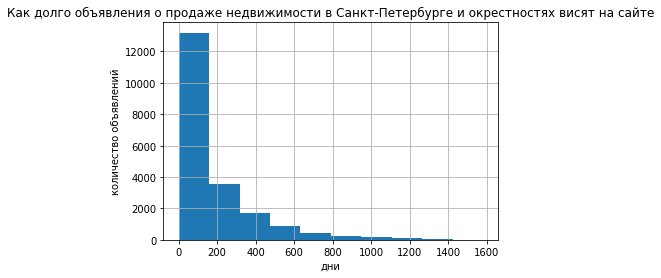

In [45]:
data['days_exposition'].hist()
plt.title('Как долго объявления о продаже недвижимости в Санкт-Петербурге и окрестностях висят на сайте')
plt.xlabel('дни')
plt.ylabel('количество объявлений')
plt.show()

In [46]:
medians_by_cat = []
grouped_data = data.groupby('square_cat')['days_exposition'].median()
medians_by_cat = grouped_data.loc[range(1, 5)].tolist()
data.loc[data['days_exposition'].isnull(),'days_exposition'] = (
        data.loc[data['days_exposition'].isnull(),'square_cat'].
        apply(get_median_by_cat)
    )    

In [47]:
data['days_exposition'].isna().sum()

0

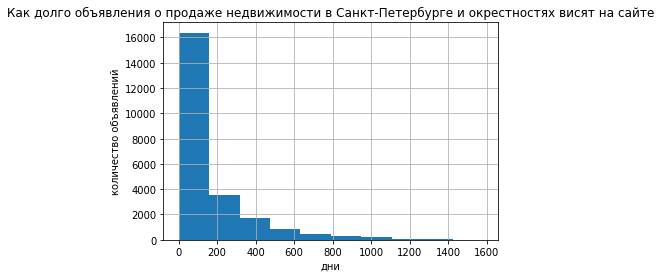

In [48]:
data['days_exposition'].hist()
plt.title('Как долго объявления о продаже недвижимости в Санкт-Петербурге и окрестностях висят на сайте')
plt.xlabel('дни')
plt.ylabel('количество объявлений')
plt.show()

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null object
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around300

<a id='4-bullet'></a>
## 2.2 Приведение данных к нужным типам

Переведем значения колонки first_day_exposition к нужному типу –  datetime. Рассмотрим случайно взятый сотый элемент.

In [50]:
data['first_day_exposition'][100]

'2018-02-22T00:00:00'

In [51]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [52]:
data['first_day_exposition'][100]

Timestamp('2018-02-22 00:00:00')

Тип данных успешно изменен. Убедимся в этом, вызвав информацию о датафрейме.

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            2760 non-null object
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_a

<a id='5-bullet'></a>
## 2.3 Поиск дубликатов

In [54]:
data.duplicated().sum()

0

Дубликаты не обнаружены

# Часть 3. Финальная подготовка таблицы к анализу

<a id='6-bullet'></a>
### Создание вспомогательных колонок

### Напомним, что 
- информация о стоимости квадратного метра содержится в колонке square m (в рублях)
- в колонке square_cat указана категория дороговизны квадратного метра, рассчитаная по квантилям: от 1 (самые недорогие квадратные метры) до 4 (очень дорогое жилье)

min         111.834862 руб

25%       76215.895611 руб

50%       94594.594595 руб

75%      113247.863248 руб

max      249375.000000 руб

день недели, месяц и год публикации объявления; ДА

этаж квартиры; варианты — первый, последний, другой; ДА

соотношение жилой и общей площади, а также отношение площади кухни к общей.

### Создадим колонки, в которых укажем день недели, месяц и год публикации объявлений

In [55]:
data['day'] = pd.DatetimeIndex(data['first_day_exposition']).dayofweek
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

### Создадим колонку, в которой укажем этажность квартиры, ограничиваясь тремя категориями:
- первый (этаж)
- последний (этаж)
- другое

In [56]:
def get_floor_type(line):
    if line['floors_total'] == line['floor']:
        return 'последний'
    if line['floor'] == 1:
        return 'первый'
    return 'другой'

In [57]:
data['floor_type'] = data.apply(get_floor_type, axis=1)

### Создадим колонки, в которых будет храниться информация о соотношении:
- площадь кухни к общей площади квартиры
- жилая площадь к общей площади квартиры


In [58]:
data['living_to_all_area'] = data['living_area']/data['total_area']

In [59]:
data['kitchen_to_all_area'] = data['kitchen_area']/data['total_area']

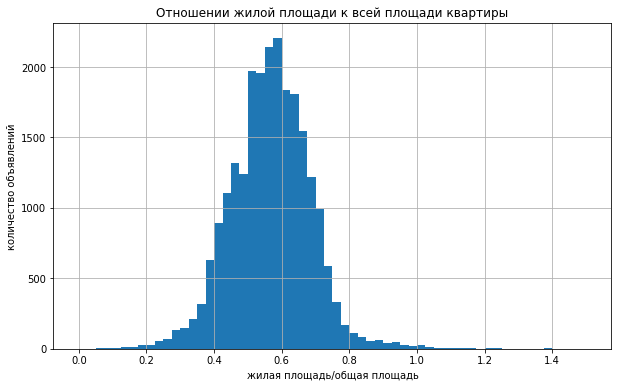

In [60]:
data['living_to_all_area'].hist(bins=60,range=(0,1.5), figsize=(10,6))
plt.title('Отношении жилой площади к всей площади квартиры')
plt.xlabel('жилая площадь/общая площадь')
plt.ylabel('количество объявлений')
plt.show()

In [61]:
data.groupby('square_cat')['living_to_all_area'].median()

square_cat
1    0.595018
2    0.596226
3    0.555556
4    0.529412
Name: living_to_all_area, dtype: float64

Во всех ценовых категориях жилья жилая площадь занимает от 50% до 60% общей площади квартиры. Чем дороже квартира, тем больше в ней нежилых площадей.

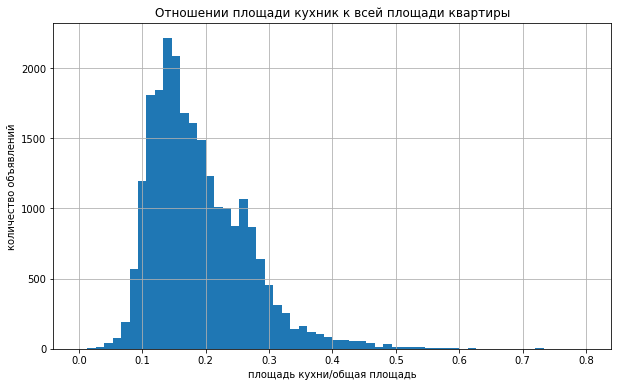

In [62]:
data['kitchen_to_all_area'].hist(bins=60,range=(0,0.8), figsize=(10,6))
plt.title('Отношении площади кухник к всей площади квартиры')
plt.xlabel('площадь кухни/общая площадь')
plt.ylabel('количество объявлений')
plt.show()

In [63]:
data.groupby('square_cat')['kitchen_to_all_area'].median()

square_cat
1    0.153846
2    0.158730
3    0.187500
4    0.200000
Name: kitchen_to_all_area, dtype: float64

Во всех ценовых категориях жилья кухня занимает от 15% до 20% общей площади квартиры. Интересно, что в более дорогих квартирах – большая доля площади приходится на кухню. То есть кухни растут не пропорционально уровню жилья, а интенсивнее.

# Часть 4. Анализ данных

<a id='7-bullet'></a>
### Характеристики самых востребованных квартир

In [64]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'square_m', 'square_cat', 'day',
       'month', 'year', 'floor_type', 'living_to_all_area',
       'kitchen_to_all_area'],
      dtype='object')

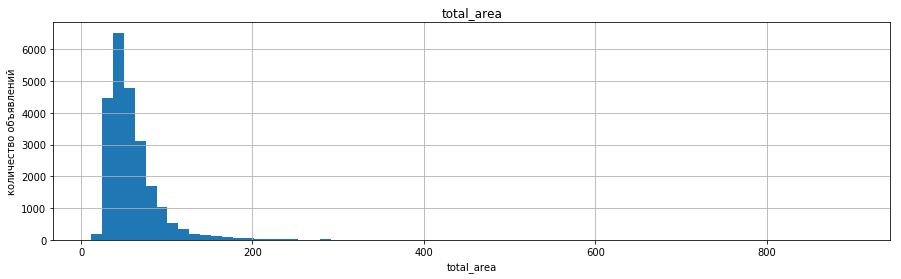

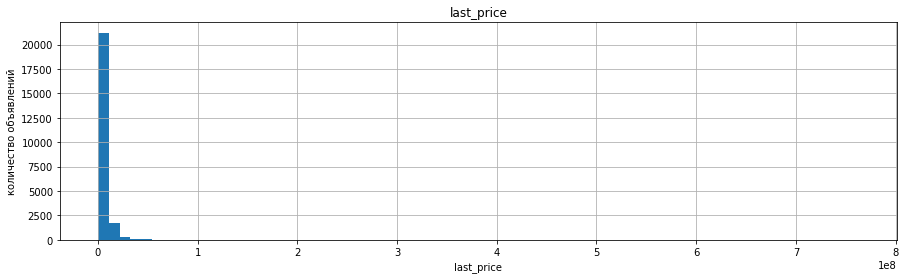

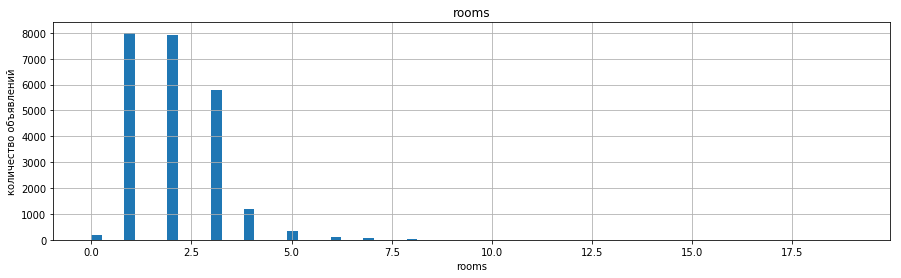

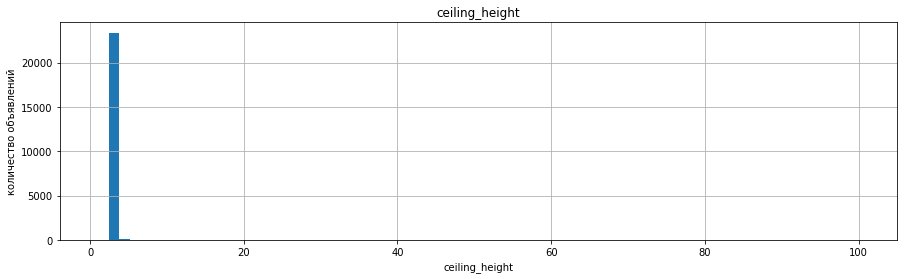

In [65]:
for i in ['total_area','last_price','rooms','ceiling_height']:
    data[i].hist(bins=70, figsize = (15,4), grid=True)
    plt.title(i)
    plt.xlabel(i)
    plt.ylabel('количество объявлений')
    plt.show()

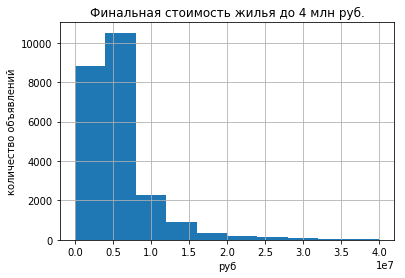

In [66]:
data['last_price'].hist(range=(0,40000000))
plt.title('Финальная стоимость жилья до 4 млн руб.')
plt.xlabel('руб')
plt.ylabel('количество объявлений')
plt.show()

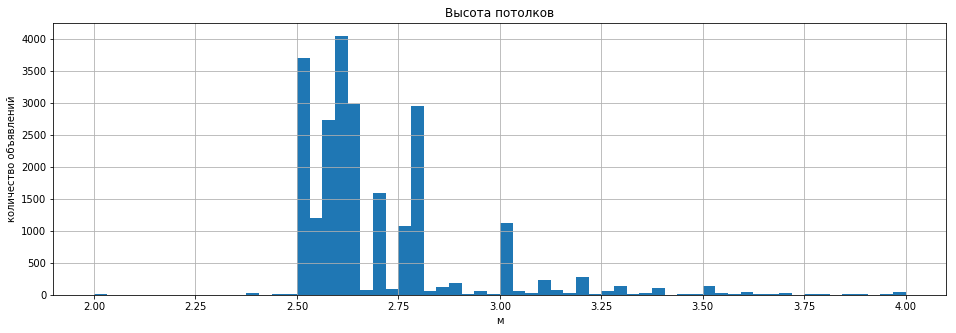

In [67]:
data['ceiling_height'].hist(bins=64, range=(2,4), figsize=(16,5))
plt.title('Высота потолков')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

In [68]:
vc = data['ceiling_height'].value_counts()
vc

2.60      4021
2.50      3515
2.80      2929
2.65      2889
2.57      2655
2.70      1571
3.00      1108
2.55       980
2.75       906
3.20       276
3.10       203
2.90       164
3.30       141
2.56       139
3.50       130
2.85       101
3.40        92
2.54        83
2.64        81
2.52        79
2.53        67
2.58        63
2.77        61
2.76        60
3.15        57
2.78        51
2.95        47
3.05        46
4.00        38
2.67        36
          ... 
2.89         1
14.00        1
3.43         1
5.50         1
3.68         1
26.00        1
3.88         1
3.29         1
3.42         1
2.34         1
4.14         1
8.30         1
4.30         1
3.98         1
4.37         1
4.65         1
100.00       1
5.00         1
5.80         1
4.90         1
3.82         1
2.49         1
4.06         1
4.15         1
1.20         1
3.39         1
27.50        1
3.59         1
4.80         1
5.60         1
Name: ceiling_height, Length: 183, dtype: int64

### Самые ходовые квартиры:
- имеют площадь около 50 квадратных метров
- стоят в переделах 10 миллионов рублей
- от 1 до 3 комнат
- высота потолков от двух до трех метров

<a id='8-bullet'></a>
### Время продажи квартир (как долго висят объявления?)

Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

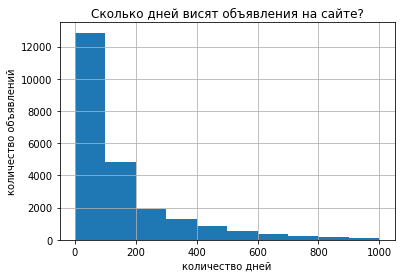

In [69]:
data['days_exposition'].hist(range=(0,1000))
plt.title('Сколько дней висят объявления на сайте?')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

### Обычно продажа занимает не более 100 дней, реже – 200 дней.

In [70]:
data['days_exposition'].median()

99.0

In [71]:
data['days_exposition'].mean()

169.41985996180776

### Заметим, что наблюдается серьезный разрвы между средним и медианой – значит есть выбросы

In [72]:
data['days_exposition'].describe()

count    23565.000000
mean       169.419860
std        206.428815
min          1.000000
25%         45.000000
50%         99.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

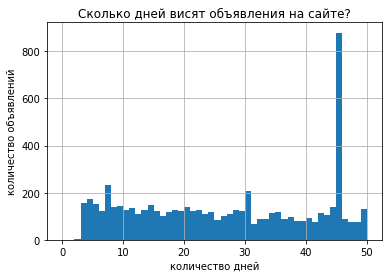

In [73]:
data['days_exposition'].hist(bins=50, range=(0,50))
plt.title('Сколько дней висят объявления на сайте?')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

На гистограмме можно заметить отчетливые выбросы – на отметках неделя, месяц, полтора месяца. Возможно, это связано с ньюансами работы риелторских агентов и их обязательствах по срокам продажи квартиры. Люди отводят себе неделю/месяц/полтора месяца на то, чтобы выбрать наилучшее предложение о покупке.

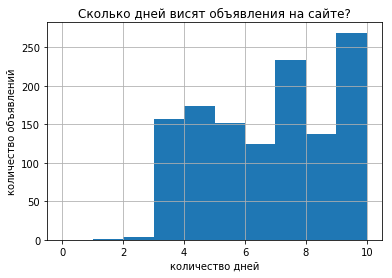

In [74]:
data['days_exposition'].hist(bins=10, range=(0,10))
plt.title('Сколько дней висят объявления на сайте?')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

Если квартира продается меньше, чем за 3 дня – это странно,  такое случается редко. Что касается жилья, которое продается дольше – почти четверть объявлений висели больше полугода.

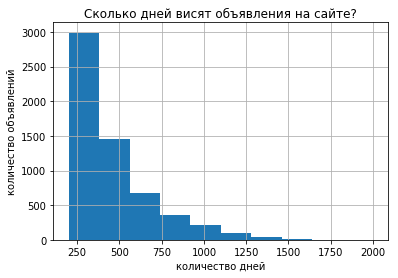

In [75]:
data['days_exposition'].hist(bins=10, range=(200,2000))
plt.title('Сколько дней висят объявления на сайте?')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

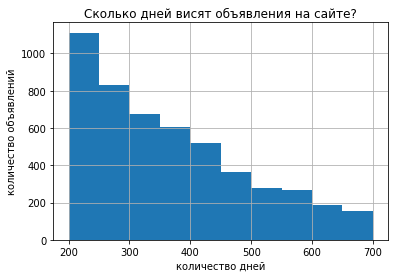

In [76]:
data['days_exposition'].hist(bins=10, range=(200,700))
plt.title('Сколько дней висят объявления на сайте?')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

In [77]:
data.query('days_exposition > 365*3')['days_exposition'].count()/data['days_exposition'].count()*100

0.6959473795883726

In [78]:
data.query('days_exposition > 365*3')['days_exposition'].count()

164

Необычайно долго это, когда объявление висит 3 года. Такие случаи составляют меньше 1% наших данных, но это целых полторы сотни случаев.

<a id='9-bullet'></a>
## Сокращение выборки

### Уберем редкие и выбивающиеся значения

#### Высота потолков

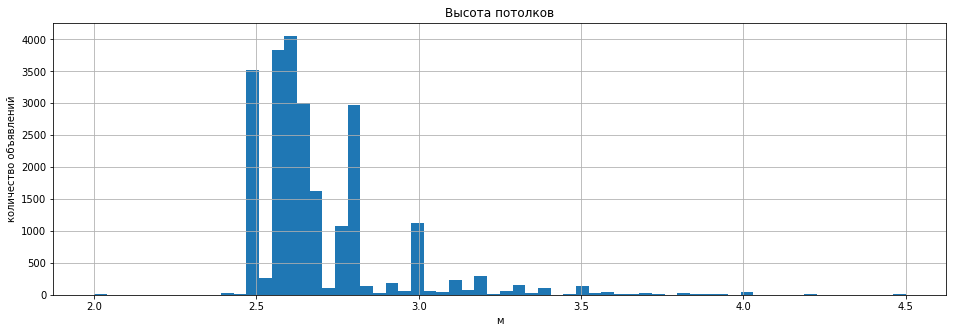

In [79]:
data['ceiling_height'].hist(bins=64, range=(2,4.5), figsize=(16,5))
plt.title('Высота потолков')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

In [80]:
data.query('ceiling_height > 3.75')['ceiling_height'].count()/data.shape[0]*100

0.7214088690855082

Потолки высотой более 3.75 метров даже в Петербурге встречаются редко – это менее 1% выборки.

#### Стоимость квартир 

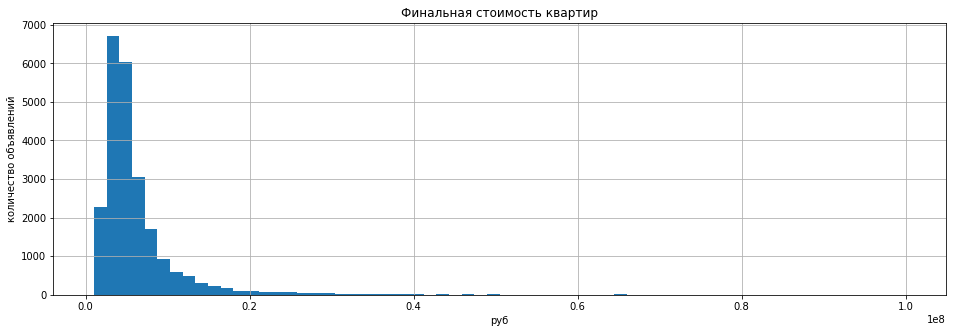

In [81]:
data['last_price'].hist(bins=64, range=(1000000,100000000),figsize=(16,5))
plt.title('Финальная стоимость квартир')
plt.xlabel('руб')
plt.ylabel('количество объявлений')
plt.show()

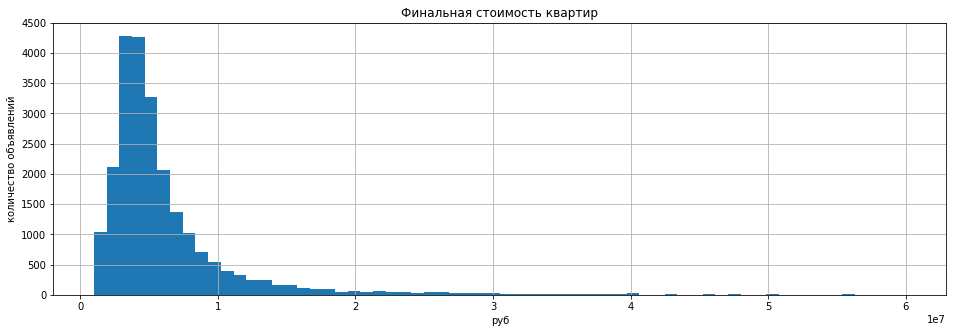

In [82]:
data['last_price'].hist(bins=64, range=(1000000,60000000),figsize=(16,5))
plt.title('Финальная стоимость квартир')
plt.xlabel('руб')
plt.ylabel('количество объявлений')
plt.show()

In [83]:
data.query('last_price > 40000000')['last_price'].count()/data.shape[0]*100

0.7680882664969234

Квартиры, стоимостью более 40 миллионов встречаются редко и составляют менее 0.8% выборки.

#### Количество комнат

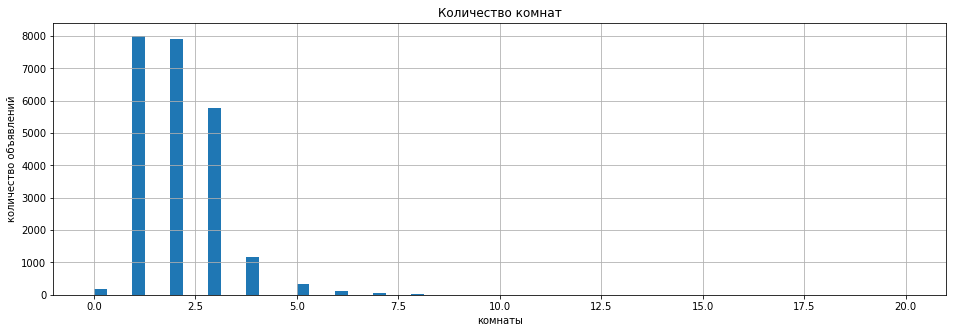

In [84]:
data['rooms'].hist(bins=64, range=(0,20),figsize=(16,5))
plt.title('Количество комнат')
plt.xlabel('комнаты')
plt.ylabel('количество объявлений')
plt.show()

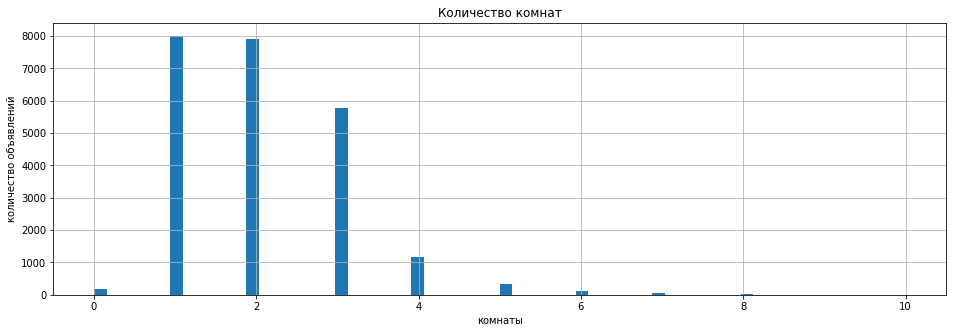

In [85]:
data['rooms'].hist(bins=64, range=(0,10),figsize=(16,5))
plt.title('Количество комнат')
plt.xlabel('комнаты')
plt.ylabel('количество объявлений')
plt.show()

In [86]:
data.query('rooms > 5')['rooms'].count()/data.shape[0]*100

0.8232548270740505

Нетипичными являются также квартиры, в которых более 5 комнат – они составляют 0.82% выборки.

#### Площадь квартиры

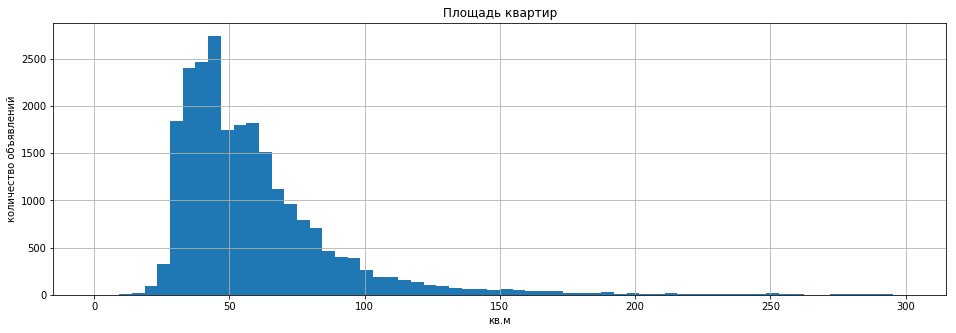

In [87]:
data['total_area'].hist(bins=64, range=(0,300),figsize=(16,5))
plt.title('Площадь квартир')
plt.xlabel('кв.м')
plt.ylabel('количество объявлений')
plt.show()

In [88]:
data.query('total_area > 200')['total_area'].count()/data.shape[0]*100

0.9590494377254403

Менее 1% квартир в продаже имели площадь более 200 кв.м

#### Таким образов, для того, чтобы сделать выборку более репрезентативной, стоит изсключить из нее следующие квартиры:
- в которых потолки выше 3.75 метров;
- стоимость которых превышает 40 миллионов рублей;
- в которых более 5 комнат;
- площадь которых превышает 200 кв м;
- которые продались менее, чем за 3 дня, или более, чем за 3 года.

In [89]:
data_filtered = data.query("""
    (ceiling_height <= 3.75)\
    and (last_price <= 40000000)\
    and (rooms <=5)\
    and (total_area <= 200)\
    and (days_exposition > 3) \
    and (days_exposition < 365*3)""")

In [90]:
data_filtered.shape[0]/data.shape[0]*100

97.04646721833228

### Набор данных уменьшился меньше, чем на 3%

<a id='10-bullet'></a>
# Какие факторы сильнее остальных влияют на стоимость квадратного метра жилья?

## Площадь?

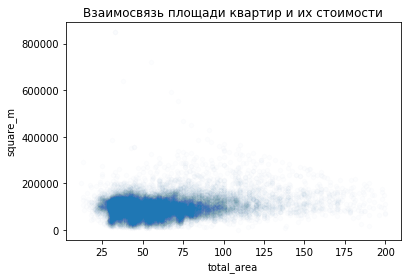

In [91]:
data_filtered.plot(kind='scatter', x='total_area', y='square_m', alpha=0.010)
plt.title('Взаимосвязь площади квартир и их стоимости')
plt.show()

In [92]:
data_filtered['total_area'].corr(data_filtered['square_m'])

0.18608973887565636

На скаттерплоте заметно вытянутое по горизонтали облако. Отчетливой зависимости между стоимостью квадратного метра и общей площадью квартиры нет. Коэффициент Пирсона подтверждает слабую взаимосвязь: 0.19.

## Число комнат?

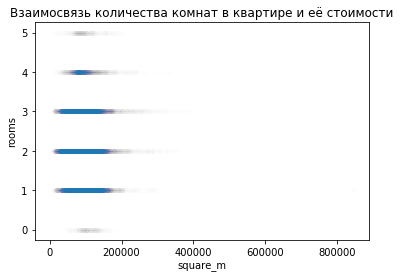

In [93]:
data_filtered.plot(kind='scatter', x='square_m', y='rooms', alpha=0.002)
plt.title('Взаимосвязь количества комнат в квартире и её стоимости')
plt.show()

In [94]:
data_filtered['rooms'].corr(data_filtered['square_m'])

-0.052288980868518346

На этом скаттерплоте облако вытянулось по вертикали, взаимосвязи между количеством комнат в квартире и стоимостью её квадратного метра не заметно. Коэффициент Пирсона это подтверждает – взаимосвязи нет (- 0.05).

In [95]:
data_filtered['rooms'].corr(data_filtered['last_price'])

0.46521089723547643

In [96]:
data_filtered['total_area'].corr(data_filtered['last_price'])

0.7717770553833917

Количество комнат и общая площадь квартиры действительно влияют на финальную стомость объекта в значительной степени (коэффициенты Пирсона 0.46 и 0.77 соответственно), однако на дороговизну квадратного метра влияния почти не имеют.

## Удаленность от центра?

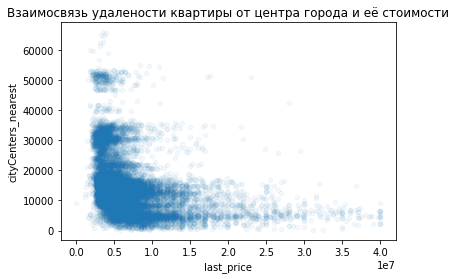

In [97]:
data_filtered.plot(kind='scatter', x='last_price', y='cityCenters_nearest', alpha=0.05)
plt.title('Взаимосвязь удалености квартиры от центра города и её стоимости')
plt.show()

In [98]:
data_filtered['last_price'].corr(data_filtered['cityCenters_nearest'])

-0.3333705618034305

Наблюдается некоторая вазаимосвязь между ценой недвижимости и отдаленностью от центра города, коэффициент корреляции Пирсона: -0.33. Чем больше показатель удаленности от центра, тем меньше стоимость квартиры, однако работает эта взаимосвязь далеко не во всех случаях. На финальную стоимость квартиры в гораздо большей степени влияют количество комнат в ней и общий метраж.

### Обратим внимание не на цену объекта, а на стоимость кв м.

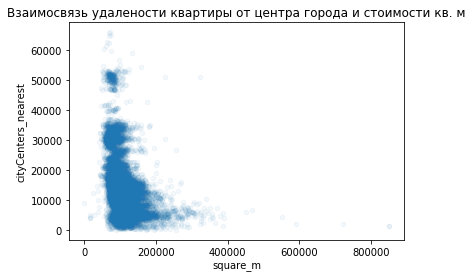

In [99]:
data_filtered.plot(kind='scatter', x='square_m', y='cityCenters_nearest', alpha=0.05)
plt.title('Взаимосвязь удалености квартиры от центра города и стоимости кв. м')
plt.show()

In [100]:
data_filtered['square_m'].corr(data_filtered['cityCenters_nearest'])

-0.3782720629548372

Взаимосвязь со стоимостью квадратного метра оказалась более сильной, чем с полной стоимостью квартиры. Сама по себе корреляция не очень сильная, но заметная. Приближенность к центру города в два раза сильнее удорожает стоимость квадратного метра жилья, чем количество комнат и общий метраж объекта. То есть не важно, большая квартира или маленькая, чем ближе она к центру, тем ценнее ее квадратный метр. Однако это правило работает далеко не во всех случаях – коэффициент корреляции Пиросна не перевалил даже за отметку 0.5.

<a id='11-bullet'></a>
### Рассмотрим отдельно объекты в Санкт-Петербурге.

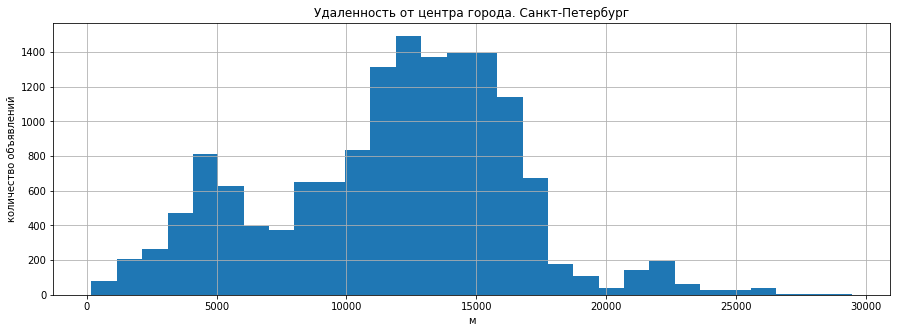

In [101]:
data_filtered.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].hist(bins=30, figsize=(15,5))
plt.title('Удаленность от центра города. Санкт-Петербург')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

Большинство недвижимости расположено в пределах 20 км от центра. Протяженность Санкт-Петербурга с севера на юг около 30 км, то есть расстояние от центра до объекта недвижимости не может превышать 15 км, если объект находится в черте города.

Между отметками 5 и 10 км от центра наблюдается спад – отчасти он объясняется тем, что на этот фрагмент приходится Финский залив – он крадет пригодную для недвижимости территорию в указанном радиусе, однако может служить границей между центральной и остальной недвижимостью.

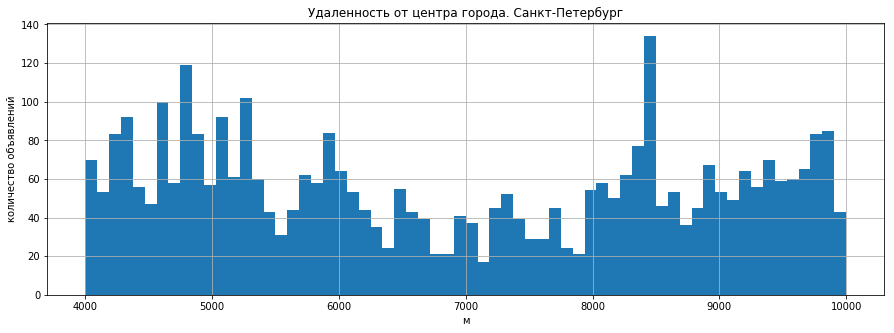

In [102]:
data_filtered.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].hist(bins=64, range=(4000,10000), figsize=(15,5))
plt.title('Удаленность от центра города. Санкт-Петербург')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

Предварительно, границей между центральной и остальной недвижимостю будем считать 7000 м. Для добства рассчетов добавим в таблицу с отфильтрованными данными столбец, в котором удаленность от центра города будет рассчитана в километрах.

In [103]:
pd.set_option('mode.chained_assignment', None)
data_filtered['km_to_center'] = data_filtered['cityCenters_nearest']/1000

In [104]:
pd.set_option('mode.chained_assignment', None)
data_filtered['km_to_center'] = data_filtered['km_to_center'].round()

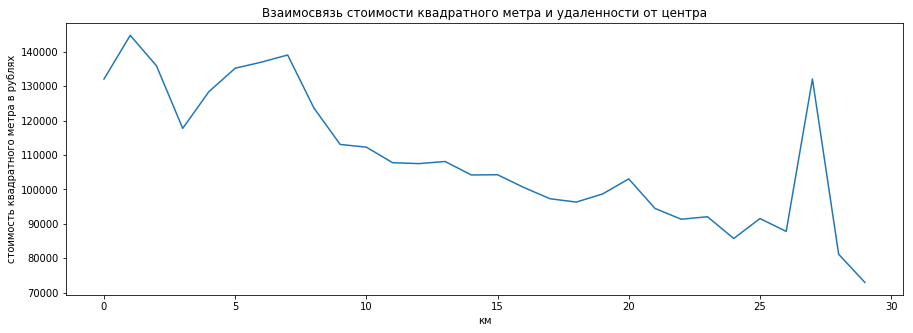

In [105]:
data_filtered.query('locality_name == "Санкт-Петербург"')\
    .groupby('km_to_center')['square_m']\
    .mean().plot(figsize=(15,5))
plt.title('Взаимосвязь стоимости квадратного метра и удаленности от центра')
plt.xlabel('км')
plt.ylabel('стоимость квадратного метра в рублях')
plt.show()

Скорее всего спад между значениями 0 и 5 км от центар действительно объясняется тем, что часть территории, на которой есть недвижимость на больших радиусов, занимает Финский залив. Если игнорировать этот провал на графике, то дорогая недвижимость (более 130 тысяч рублей за кв.м) лежит между значениями 0 и 10, рассмотрим их внимательнее.

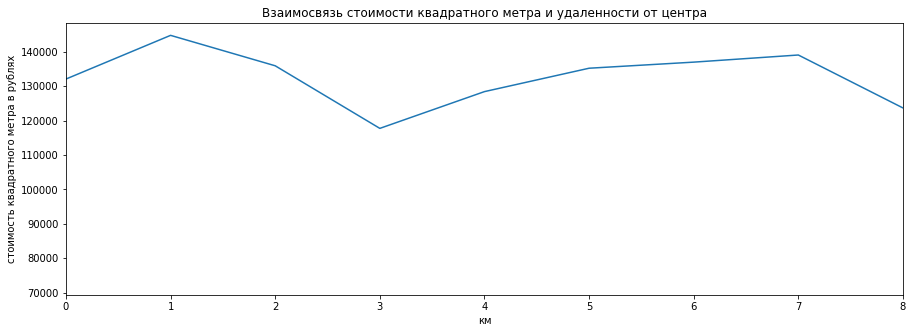

In [106]:
data_filtered.query('locality_name == "Санкт-Петербург"')\
    .groupby('km_to_center')['square_m']\
    .mean()\
    .plot(figsize=(15,5))
plt.xlim(left=0, right=8)
plt.title('Взаимосвязь стоимости квадратного метра и удаленности от центра')
plt.xlabel('км')
plt.ylabel('стоимость квадратного метра в рублях')
plt.show()

Средняя стоимость квадратного метра начинает падать с отметки 7 км от центра. Так, подтвердим отметку сегмента дорогих квартир в центре как объекты в радиусе 7 км от центра Санкт-Петербурга.

In [107]:
spb_center = data_filtered.query('km_to_center <= 7')
spb_outskirts = data_filtered.query('km_to_center > 7')

total_area


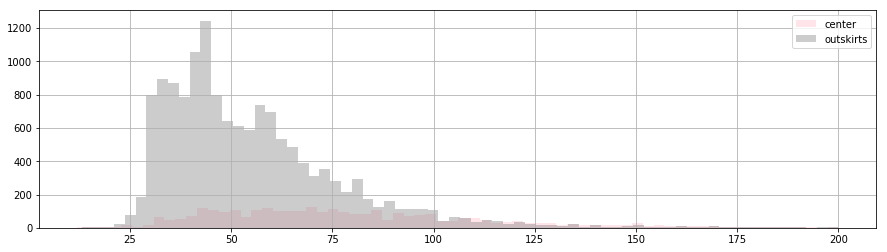

last_price


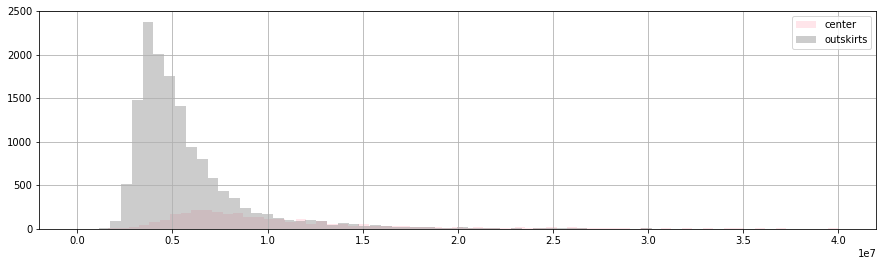

rooms


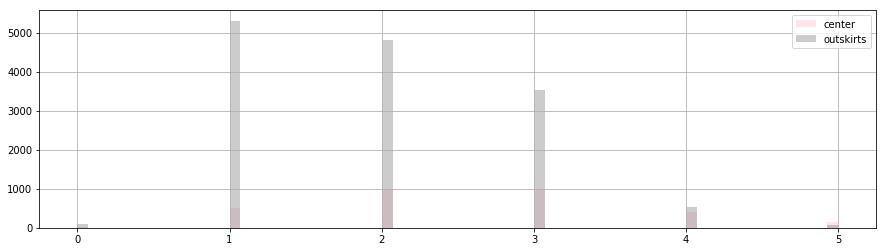

ceiling_height


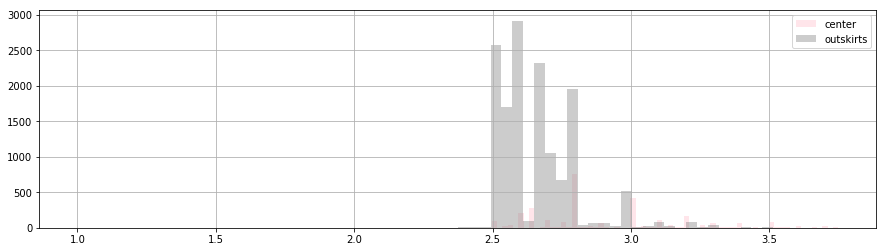

days_exposition


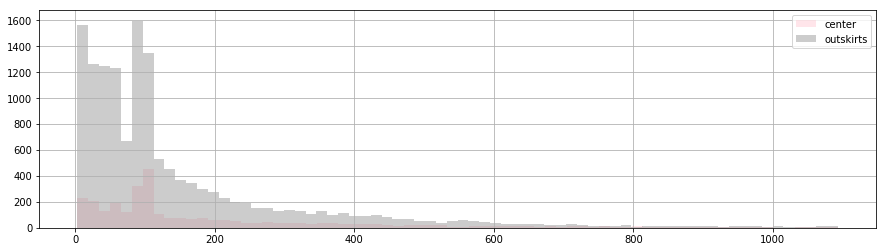

In [108]:
for i in ['total_area','last_price','rooms','ceiling_height','days_exposition']:
    print(i)
    spb_center[i].hist(bins=70, figsize = (15,4), grid=True, label = 'center', color = 'pink', alpha=0.4)
    spb_outskirts[i].hist(bins=70, figsize = (15,4), grid=True, label = 'outskirts', color = 'grey', alpha=0.4)
    plt.legend()
    plt.show()

### На графиках выше ничего не понятно. Их необходимо нормализовать!

total_area


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


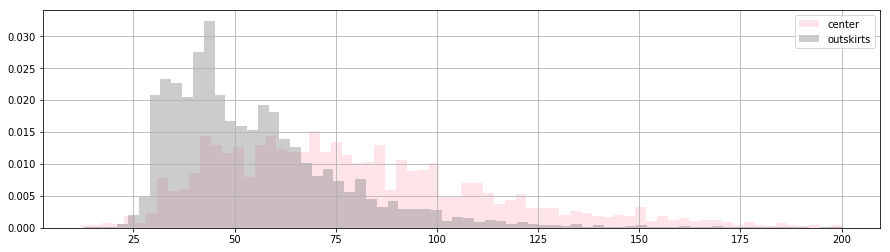

last_price


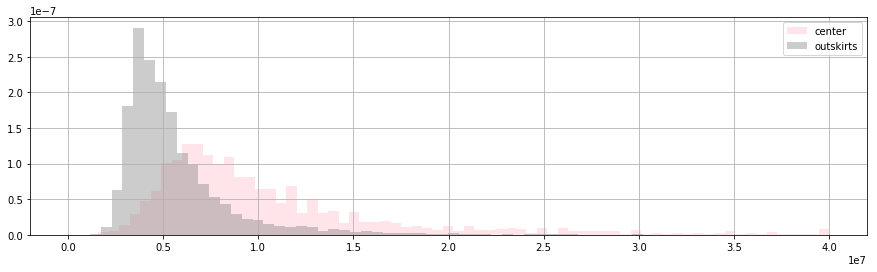

rooms


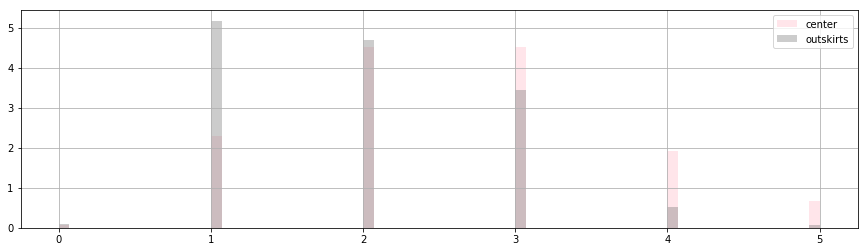

ceiling_height


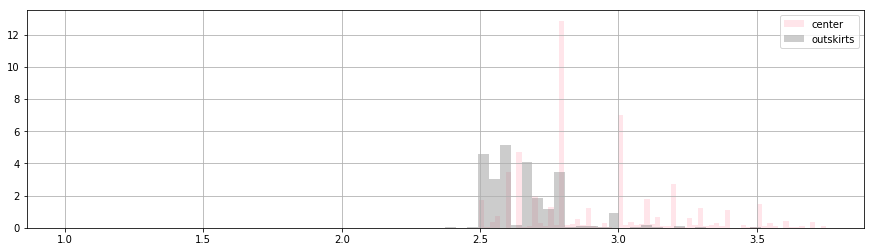

days_exposition


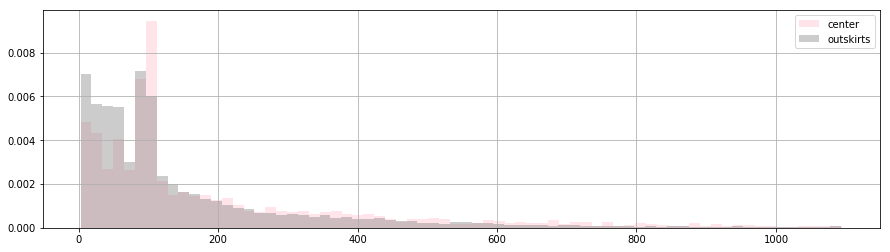

In [109]:
for i in ['total_area','last_price','rooms','ceiling_height','days_exposition']:
    print(i)
    spb_center[i].hist(bins=70, figsize = (15,4), grid=True, color = 'pink', label = 'center', alpha=0.4, normed=True)
    spb_outskirts[i].hist(bins=70, figsize = (15,4), grid=True, color = 'grey', label = 'outskirts', alpha=0.4, normed=True)
    plt.legend()
    plt.show()

### Квартиры в центре Санкт-Петербурга:
- больше по площади, чем в на окраинах: 
    в центре в 2 раза реже встречаются квартиры площадью до 50 кв м, и в два раза чаще квартиры площадью от 75 кв м;
- дороже, чем в среднем в городе – в два раза;
- имеют больше комнат:
    гораздо чаще, чем на окраинах встречаются 3,4 и 5 комнатные квартиры;
- потолки выше:
    популярный вариант 2.8 метров, часто встречаются объекты с потолками выше 3 метров, чего вообще нет на окраине города;
- продаются квартиры в центре и на окраине одинаково долго.

# Отвлечемся от Санкт-Петербурга и вернемся к общему датасету
## Зависит ли цена квартиры от этажа?

#### Первые этажи: медианная стоимость кв метра в рублях

In [110]:
data_filtered.query('floor_type == "первый"')['square_m'].median()

81022.53559651709

#### Последние этажи: медианная стоимость кв метра в рублях

In [111]:
data_filtered.query('floor_type == "последний"')['square_m'].median()

86725.66371681416

#### Остальные этажи: медианная стоимость кв метра в рублях

In [112]:
data_filtered.query('floor_type == "другой"')['square_m'].median()

97972.97297297297

Самые востребованные этажи – между первым и последним. Самыми дешевыми оказываются объекты на первом этаже. Дороже их, но дешевле остальных, квартиры на последнем этаже.

#### А если смотреть только на Санкт-Петербург?

In [113]:
data_filtered.query('(floor_type == "первый") & (locality_name == "Санкт-Петербург")')['square_m'].median()

93012.42236024844

In [114]:
data_filtered.query('(floor_type == "последний") & (locality_name == "Санкт-Петербург")')['square_m'].median()

101239.80531439095

In [115]:
data_filtered.query('(floor_type == "другой") & (locality_name == "Санкт-Петербург")')['square_m'].median()

106412.34073838271

Такая же динамика в зависимости стоимости квадратного метра от этажа наблюдается и в Санкт-Петербурге.

# От даты размещения?

Дни недели

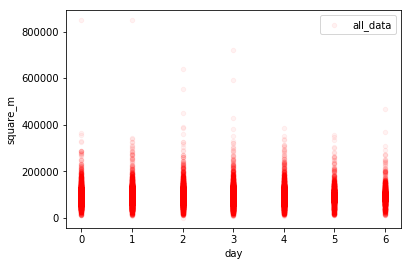

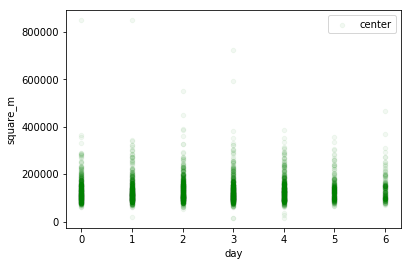

In [116]:
data_filtered.plot(kind='scatter', x='day', y='square_m', label = 'all_data', alpha=0.05, color = 'red')
spb_center.plot(kind='scatter', x='day', y='square_m', label = 'center', alpha=0.05, color = 'green')

Месяц

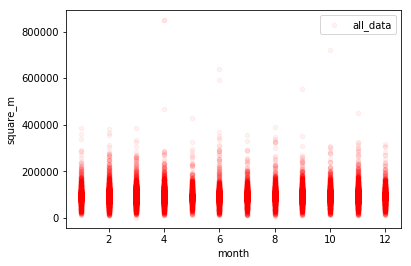

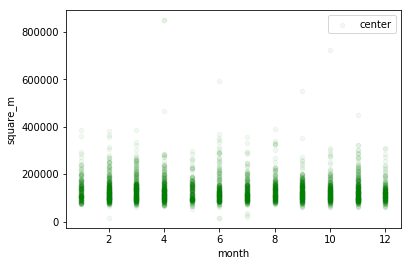

In [117]:
data_filtered.plot(kind='scatter', x='month', y='square_m',  label = 'all_data', alpha=0.05, color = 'red')
spb_center.plot(kind='scatter', x='month', y='square_m',  label = 'center', alpha=0.05, color = 'green')

Год

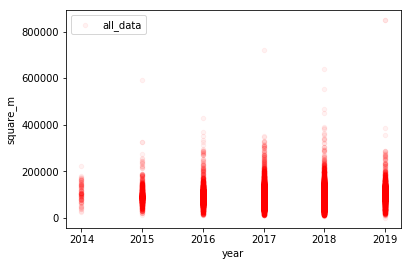

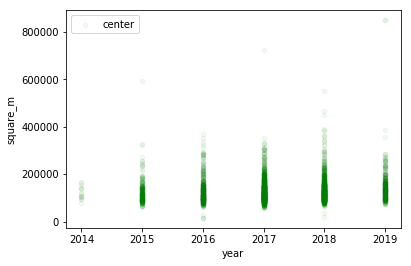

In [118]:
data_filtered.plot(kind='scatter', x='year', y='square_m', label = 'all_data', alpha=0.05, color = 'red')
spb_center.plot(kind='scatter', x='year', y='square_m', label = 'center', alpha=0.05, color='green')


Зависимости от даты размещения нет: ни во всей выборке, ни конкретно в Питере.

<a id='12-bullet'></a>
# Недвижимость в окрестностях Санкт-Петербурга

In [119]:
top_towns = data_filtered.query('locality_name != "Санкт-Петербург"')\
    .groupby('locality_name')['locality_name']\
    .count().sort_values(ascending=False)[0:10].index

In [120]:
top_towns_data = data_filtered.query('locality_name in @top_towns')

In [121]:
top_towns_data.groupby('locality_name')['square_m'].mean().sort_values(ascending = True)

locality_name
Выборг                58145.610101
Всеволожск            68571.875125
Гатчина               68811.372828
Колпино               75310.766883
посёлок Шушары        78486.545900
Петергоф              84536.162121
посёлок Мурино        85708.113847
посёлок Парголово     90259.743484
деревня Кудрово       92454.342295
Пушкин               102666.319669
Name: square_m, dtype: float64

In [122]:
top_towns_data.groupby('locality_name')['square_m'].mean().sort_values(ascending = False)

locality_name
Пушкин               102666.319669
деревня Кудрово       92454.342295
посёлок Парголово     90259.743484
посёлок Мурино        85708.113847
Петергоф              84536.162121
посёлок Шушары        78486.545900
Колпино               75310.766883
Гатчина               68811.372828
Всеволожск            68571.875125
Выборг                58145.610101
Name: square_m, dtype: float64

Рядом с Санкт-Петербургом самая доступная недвижимость в Выборге, Всеволжске и Гатчине.

Самая дорогая – в Пушкине, деревне Кудрово и поселке Парголово.

<a id='13-bullet'></a>
# ВЫВОДЫ

- Рыночная стоимость объектов недвижимости в первую очередь связана: с количеством комнат в объекте и площадью объекта (коэффициент корреляции Пирсона почти 0.8). 
- На стоимость квадратного метра в объекте вообще не влияет количество комнат в нем (коэффициент Пирсона -0.05), очень слабо влияет общий метраж квартиры (0.186) и более значительно, но все еще не радикально, влияет удаленность квартиры от цента города (-0.33). Таким образом, ограничиваясь такими факторами, как количество комнат, площадь жилья и удаленность от центра, наибольшее влияние на стоимость квадратного метра, а значит о финальную стоимость недвижимости, имеет расстояние до центра города. Скорее более значимый вклад в ценность квадратного метра вносит год постройки дома и класс этого жилья – это вопрос будущих исследований.
    
- В центре города почти в два раза выше вероятность встретить большую квартиру (от 75 кв. м) с 3-5 комнатами и высокими потолками (2.8 метров и более)

- Самые ходовые этажи в Санкт-Петербурге и окрестностях – не первые и не последние. Проблема первых этажей понятна – отсутствие приватности, что касается последних этажей, то возможно дело в частых осадках и обилии исторической застройки с проблемными крышами.